# TP d'OCVX : démélange spectral par moindres carrés et régularisation 

**/!\** Avant de débuter le TP, vous devez avoir lu la petite introduction sur le démélange spectral. Les notations sont les mêmes que dans le document, et les termes spécifiques ne sont pas réintroduits ici.

L'objectif de ce TP est de vous faire manipuler la résolution d'un problème concret (en l'occurrence, le démélange spectral) par méthode des moindres carrés ordinaires, et de vous montrer ce qu'il est possible de faire lorsque le problème est mal posé via les méthodes de régularisation classiques.

Pour le moment, nous n'avons pas le bagage théorique nécessaire à résolution complète du problème de démélange spectral, c'est à dire en intégrant les contraintes de positivité et de somme à 1 pour les abondances. Mais le démélange n'est ici qu'un prétexte, on prendra juste garde à ne pas chercher à interpréter les résultats obtenus pour les abondances en termes de proportions (sauf si vous arrivez à obtenir des abondances positives et sommant à 1 uniquement avec les méthodes abordées dans ce TP, auquel cas, on écrira directement une publication$\dots$)

## I. Introduction

In [6]:
# Les imports de base
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
from scipy import spatial
import skimage
from skimage import exposure

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sn

On commence par importer les données (hsi $=$ *hyperspectral image*), et une vérité terrain (*gt $=$ ground truth*) normalement utilisée pour de la classification (mais elle va nous permettre de générer la matrice d'endmembers $\mathbf{E}$ à moindres frais).

Les données sont de suite normalisées entre 0 et 1 (correspondant à peu près à une conversion radiance $\Rightarrow$ réflectance).

In [7]:
hsi = np.load('data/pavia.npy')
gt = np.load('data/groundtruth.npy')
hsi = hsi/hsi.max() # conversion de la réflectance en radiance
Nrow,Ncol,Nbands = hsi.shape # sera utile plus tard pour les conversions tenseur 3D/matrice
Npix = Nrow*Ncol
print(hsi.shape)

(610, 340, 103)


On vérifie tout de suite les dimensions de l'image : $610$ lignes, $340$ colonnes et $103$ bandes spectrales.


Quelques infos : la scène a été acquise au dessus de l'université de Pavie, en Italie, par le capteur ROSIS 03 (*Reflective Optics System Imaging Spectrometer*). La résolution spatiale du capteur est de $2.6$ m (autrement dit, un pixel couvre une zone de $2.6 \times 2.6$ m au sol). Les $103$ bandes spectrales s'étalent de $430$ nm à $860$ nm, avec une largeur de bande de $4.0$ nm.

Pour visualiser cette image, il va tout d'abord falloir en extraire une image RGB, donc sélectionner un canal de rouge, un canal de vert et un canal de bleu parmi les $103$ bandes spectrales. Pour ce jeu de données, on utiliser en général $R = 47$, $G = 26$ et $B = 10$.

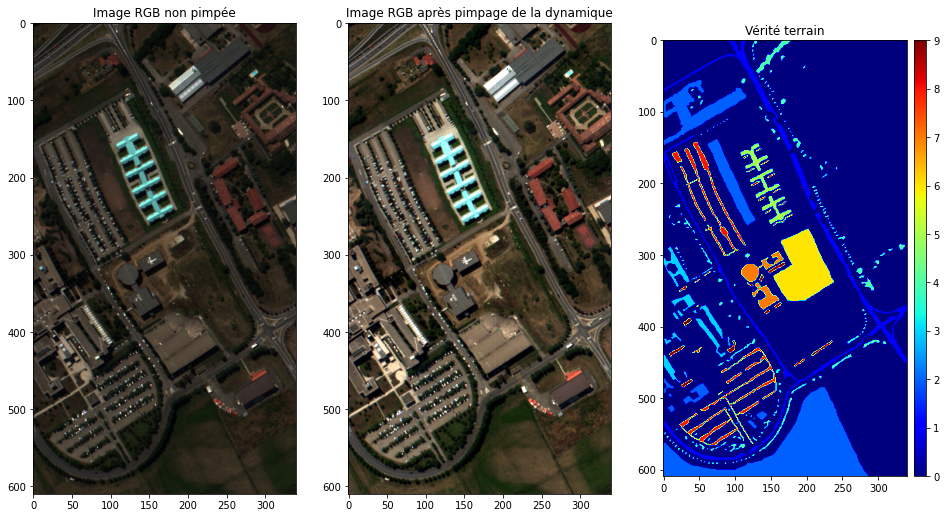

In [8]:
# Par convention, les bandes RGB de cette image sont R=47, G=26 et B=10
hsi_rgb = hsi[:,:,[47,26,10]]

# Réétalonne la dynamique de l'histogramme de chaque bande RGB (étire l'histogramme comprit entre 1% et 99%)
perc = 1
plow, phigh = np.percentile(hsi_rgb, (perc, 100-perc))
pimp_my_hsi_rgb = exposure.rescale_intensity(hsi_rgb, in_range=(plow, phigh))

# Affiche tout ce bazar
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Image RGB non pimpée')
plt.imshow(hsi_rgb)
plt.subplot(132)
plt.imshow(pimp_my_hsi_rgb)
plt.title('Image RGB après pimpage de la dynamique')
plt.subplot(133)
ax = plt.gca()
plt.title('Vérité terrain')
imgt = ax.imshow(gt,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

Pour la vérité terrain ci-dessus, chacune des 9 classes présentent dans l'image est identifiée par un label allant de $1$ à $9$ (la classe $0£ étant, par convention, le fond de l'image). La correspondance des labels avec leur classe sémantique est donné ci-dessous

| label | classe |
|  ---  |   ---  | 
| 1 | Asphalte |
| 2 | Champ/herbe |
| 3 | Gravier |
| 4 | Végétation |
| 5 | Plaques de métal peintes |
| 6 | Sol nu|
| 7 | Bitume |
| 8 | Briques autobloquantes |
| 9 | Ombre |

Plutôt que d'utiliser un algorithme d'induction aveugle d'endmembers ou une bibliothèque spectrale, on va se servir de la vérité terrain pour construire la matrice d'endmembers $\mathbf{E}$.

On va cependant exclure la classe "ombre", qui ne peut pas être considéré comme un constituant macroscopique pur. Pour les classes de $1$ à $8$, on va définir la signature spectral de l'endmember correspondant comme étant le médoïde de tous les pixels appartenant à la classe.

**1.1) Quelle est la différence principale entre le centroïde et le médoïde d'un ensemble de points ? Quel est le principal avantage du médoïde par rapport au centroïde ?**

Les Medoides sont des points du dataset alors que les centroides sont des points estimes.

Les Medoides sont plus robuste au bruit et au anomalies statistiques.

L'algorithme de calcul du médoïde d'un ensemble de points est donné ci-dessous (il n'est pas nécessaire d'essayer de le comprendre)

In [95]:
# vecteur médoïde xmed de X [Nsamples,Nfeatures]
# (pompé sans aucune honte quelque part sur le net)
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = sp.spatial.distance.cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if sp.spatial.distance.euclidean(y, y1) < eps:
            return y1

        y = y1

On peut donc constituer la matrice d'endmembers $\mathbf{E} \in \mathbb{R}^{N_{bands} \times m}$, en récupérant le médoïde de chacune des $m=8$ premières classes de la vérité terrain. $N_{bands}$ étant évidemment le nombre de bandes dans l'image hyperspectrale

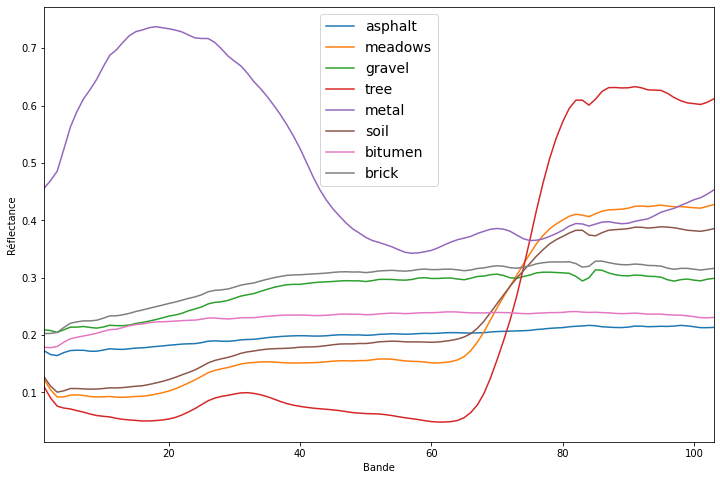

In [96]:
# liste des noms des constituants macroscopiques
endmembers = ['asphalt','meadows','gravel','tree','metal','soil','bitumen','brick']
# m => nombre total d'endmembers considérés
m = len(endmembers)
# E => matrice Nbands x m
E = np.zeros((Nbands,m))
# vectorisation du cube 3D (Nrow x Ncol x Nbands) en matrice (Npix x Nbands)
hsir = hsi.reshape(Npix,Nbands)
# extraction du médoïde pour chaque classe
for c in range(1,m+1): # indice des classes commençant à 1
    class_idx = (gt==c).ravel() # indices vectorisé des pixels appartenant à la classe c
    all_spectra = hsir[class_idx,:] # récupération des spectres correspondants (lignes de la matrice hsir)
    E[:,c-1] = geometric_median(all_spectra) # calcul du médoïde et stockage dans E
    
# On affice les signatures spectrales des 8 endmembers
plt.figure(figsize=(12,8))
for m,em in enumerate(endmembers):
    plt.plot(np.arange(1,104),E[:,m],label=em)
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

## II. Démélange par moindres carrés ordinaires

On attaque maintenant le vif du sujet. Étant donnés la matrice d'endmembers $\mathbf{E} = [\mathbf{e}_1,\dots,\mathbf{e}_m] \in \mathbb{R}^{N_{bands} \times m}$ et le spectre $\mathbf{x} \in \mathbb{R}^{N_{bands}}$ d'un pixel, on veut récupérer les abondances fractionnelles $\boldsymbol \phi = [\phi_1,\dots,\phi_m]$ de $\mathbf{x}$.

D'après le LMM, $\mathbf{x}$ s'écrit comme la combinaison linéaire des endmembers $\mathbf{e}_i$ pondérés par leur abondance fractionnelle $\phi_i$ correspondante (plus un bruit additif indépendant pour modéliser les imprefections du modèle) :
$$ \mathbf{x} = \sum_{i=1}^m \phi_i \mathbf{e}_i + \boldsymbol \eta = \mathbf{E} \boldsymbol \phi + \eta$$

L'inversion de ce modèle revient à calculer le vecteur $\boldsymbol \phi$ qui minimise la _residual sum of squares_ $RSS(\boldsymbol \phi) = \displaystyle \sum_{i=1}^{N_{bands}} \big(x(i) - [\mathbf{E}\boldsymbol \phi](i)\big)^2 = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2$ :

$$ \boldsymbol \phi = \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 \quad (1)$$

**2.1) Retrouver analytiquement la solution du problème (1).**

Il s'agira d'exprimer $\boldsymbol \phi$ en fonction de $\mathbf{E}$ et $\mathbf{x}$.

Vous devez coder la solution analytique vous même dans un premier temps. Ce n'est que dans un second temps que vous pourrez vous rassurer (ou pas) en vérifiant que vous obtenez bien la même chose qu'un solveur de moindres carrés ordinaires.

Démélangez dans un premier temps des spectres appartenant à l'une des 8 classes.

TODO: Cf DM

On pose $f(\phi) = \lVert b-A\phi \rVert_2^2$.\
Pour minimiser $f$, on cherche à résoudre $\nabla(f) = \vec{0}$.\
\begin{align*}
    f(\phi) &= \lVert b - A\phi \rVert_2^2\\
    &= (b-A\phi)^T(b-A\phi)\\
    &= b^Tb - b^TA\phi - \phi^TA^Tb + \phi^TA^TA\phi
\end{align*}


In [97]:
def analytic_solution(E, x):
    return np.linalg.inv(E.T @ E) @ E.T @ x

**2.2) En théorie, quelle devrait être la composition du vecteur d'abondances $\boldsymbol \phi$? Et qu'en est-il en pratique ? Comparez graphiquement le spectre initial $\mathbf{x}$ avec sa reconstruction $\hat{\mathbf{x}} = \mathbf{E}\boldsymbol \phi$**

En theorie, $\boldsymbol \phi$ devrait etre compose de probabilites (entre 0 et 1) pour chaque pixel et chaque endmember. Pour chaque pixel, la somme devrait etre egale a 1.

En pratique, ce n'est pas le cas, car dans notre modele nous n'avons pas considere les containtes.

In [102]:
x = hsi[3, 3]
x_hat = E @ analytic_solution(E, x)

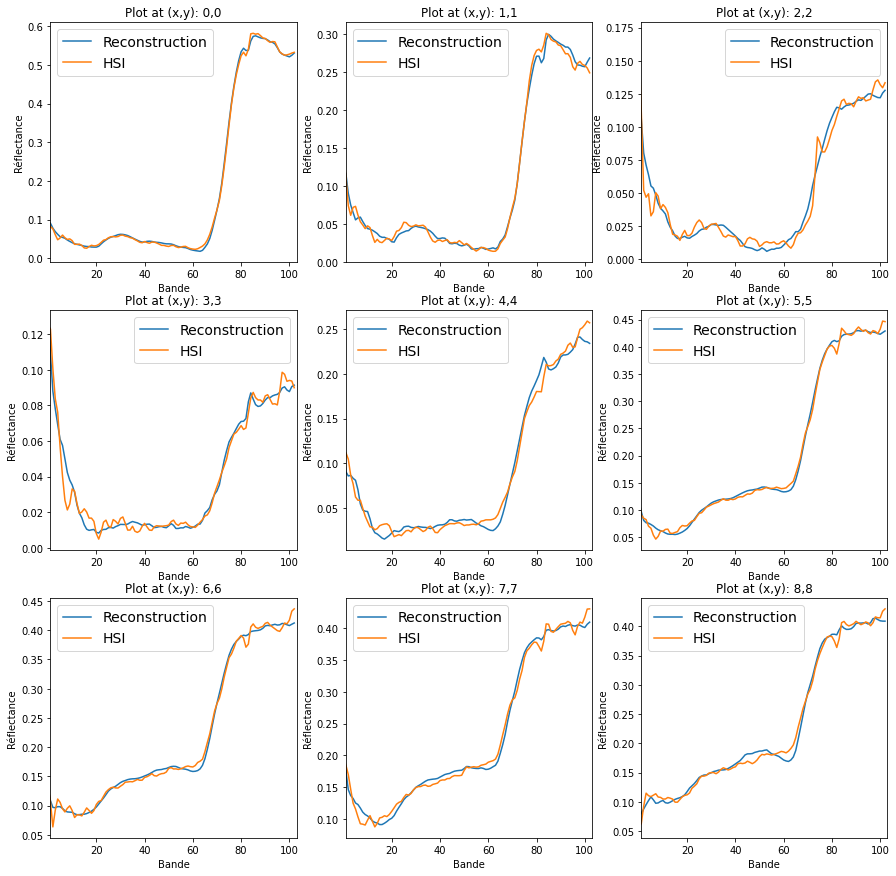

In [109]:
plt.figure(figsize=(15,15))

for i in range(9):
    x = hsi[i, i]
    x_hat = E @ analytic_solution(E, x)
    
    plt.subplot(3, 3, i + 1)
    plt.plot(x_hat, label='Reconstruction')
    plt.plot(x, label='HSI')
    plt.title("Plot at (x,y): {},{}".format(i, i))
    plt.xlim((1,103))
    plt.xlabel('Bande')
    plt.ylabel('Réflectance')
    plt.legend(loc='best',fontsize=14)
plt.show()

On remarque que l'estimation est plutot bonne et la donnee est bien reconstruite.

Il est coutûme de mesurer quantitativement la qualité de démélange de $\mathbf{x}$ par l'erreur quadratique moyenne entre $\mathbf{x}$ et sa reconstruction $\mathbf{\hat{x}} = \sum_{i=1}^m \phi_i \mathbf{e}_i$ :

$$\epsilon(\mathbf{x},\mathbf{\hat{x}}) = \sqrt{\frac{1}{N_{bands}} \sum_{i=1}^{N_{bands}} (x(i) - \hat{x}(i))^2} \quad (2)$$

**2.3) Implémentez la fonction d'erreur quadratique moyenne. Quel ordre de grandeur obtenez vous pour les spectres démélangées précédemment ?**

In [14]:
def mean_square_error(x, x_hat):
    return np.sqrt(np.mean((x - x_hat) ** 2))

In [110]:
for i in range(9):
    x = hsi[i, i]
    x_hat = E @ analytic_solution(E, x)
    print("MSE at ({},{}): {}".format(i, i, mean_square_error(x, x_hat)))

MSE at (0,0): 0.0056201638319814135
MSE at (1,1): 0.007160289618799799
MSE at (2,2): 0.008818191357932404
MSE at (3,3): 0.005436003746510818
MSE at (4,4): 0.009957902498334344
MSE at (5,5): 0.007128036978130068
MSE at (6,6): 0.007999278502239226
MSE at (7,7): 0.009663426368438118
MSE at (8,8): 0.009918035512718967


In [113]:
mses = np.empty((Nrow * Ncol))
for i in range(Nrow):
    for j in range(Ncol):
        x = hsi[i, j]
        x_hat = E @ analytic_solution(E, x)
        mses[i * Ncol + j] = mean_square_error(x, x_hat)
        
mses.mean()

0.00740278123521922

L'ordre de grandeur des erreurs est au centieme pres.

Démélanger pixel par pixel, c'est bien. Mais s'il était possible d'obtenir d'un coup les abondances fractionnelles de tous les pixels de l'image, ça serait vachement mieux. Et ça tombe bien, car c'est possible : il suffit d'utiliser la modélisation matricielle de l'image hyperspectrale $\mathbf{X} \in \mathbb{R}^{N_{bands} \times N_{pix}}$ et d'étendre le problème (1) sous la forme 

$$\boldsymbol \Phi = \arg\min_{\Phi \in \mathbb{R}^{m\times N_{pix}}} = \|\mathbf{X} -  \mathbf{E}\Phi \|_2^2 \quad (1)$$

La solution $\boldsymbol \Phi \in \mathbb{R}^{m\times N_{pix}}$ obtenue s'interprète donc comme une matrice d'abondances fractionnelles, où chaque colonne contient le vecteur d'abondance $\boldsymbol \phi$ du pixel correspondant. Cette matrice peut se réorganiser à moindres frais en un cube 3D $(N_{row} \times N_{col} \times m)$, où chaque canal peut se visualiser comme la carte d'abondances fractionelles de l'image entière pour l'endmember considéré.

**2.4) Adaptez votre implémentation de la question 2) pour obtenir la matrice d'abondance $\boldsymbol \Phi$ en un coup**

In [16]:
phi = analytic_solution(E, hsi.reshape((-1, Nbands)).T)

In [18]:
x_hat = E @ phi

In [22]:
x_reshaped = hsi.reshape((-1, 103))

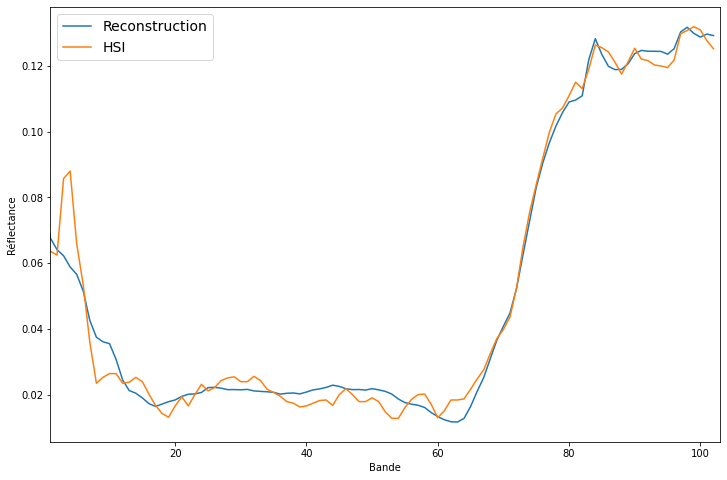

In [23]:
plt.figure(figsize=(12,8))
plt.plot(x_hat[:, 10], label='Reconstruction')
plt.plot(x_reshaped[10, :], label='HSI')
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

**2.5) Réorganisez la matrice précédente en un cube 3D et visualisez les différentes cartes d'abondances pour les 8 endmembers. Que remarquez vous/pouvez vous en conclure ?**

In [24]:
phi.shape

(8, 207400)

In [25]:
phi_reshape = phi.reshape((8, Nrow, Ncol))

In [26]:
phi_reshape[0]

array([[-1.21999646, -2.25061442,  2.18942364, ...,  0.94527578,
         0.21970084,  1.66171782],
       [-2.40187802, -2.33194507,  4.16881118, ...,  0.84555412,
        -1.53355221,  0.96382537],
       [-3.03342981, -2.75210272,  1.20867982, ...,  3.01271774,
         3.78525839,  3.56591096],
       ...,
       [ 1.73076629,  0.41556068,  2.52786312, ..., -0.10865688,
         0.53943552, -2.59864867],
       [ 1.29629996,  0.92697889,  0.7014925 , ..., -0.05963629,
         1.14115246, -1.37642033],
       [ 1.14752285,  1.40472418,  0.23889877, ...,  1.04790928,
         0.0224121 , -0.56792033]])

In [27]:
#phi_reshape[0] = np.interp(phi_reshape[0], (phi_reshape[0].min(), phi_reshape[0].max()), (0, 1))

In [81]:
phi.shape

(8, 207400)

In [90]:
mi = phi.min(axis=1).reshape((-1, 1))
ma = phi.max(axis=1).reshape((-1, 1))

phi_rescale = (phi - mi) / (ma - mi)

In [91]:
phi_rescale

array([[0.45736646, 0.44941128, 0.48368325, ..., 0.47487207, 0.46695642,
        0.46239974],
       [0.52961044, 0.53221491, 0.52925627, ..., 0.53687015, 0.53730086,
        0.52436749],
       [0.49712472, 0.50541127, 0.48855507, ..., 0.48316653, 0.49630313,
        0.50457716],
       ...,
       [0.41683219, 0.4161167 , 0.42001469, ..., 0.42339837, 0.42274106,
        0.43539913],
       [0.42170527, 0.42723563, 0.40534843, ..., 0.40813038, 0.41449047,
        0.41867869],
       [0.53201181, 0.5253462 , 0.53767117, ..., 0.54103222, 0.53076645,
        0.52160542]])

In [93]:
phi_rescale_reshape = phi_rescale.reshape((8, 610, 340))

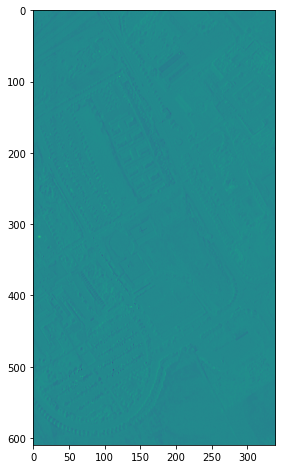

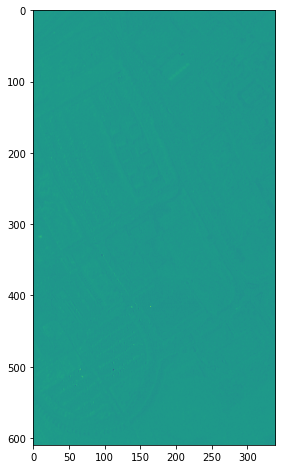

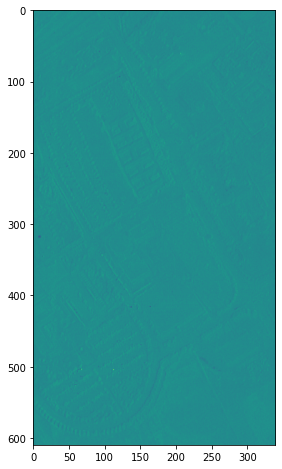

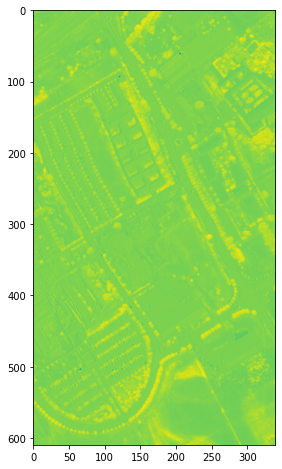

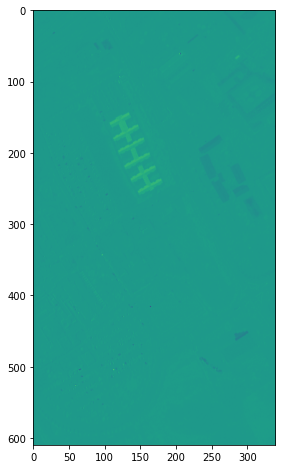

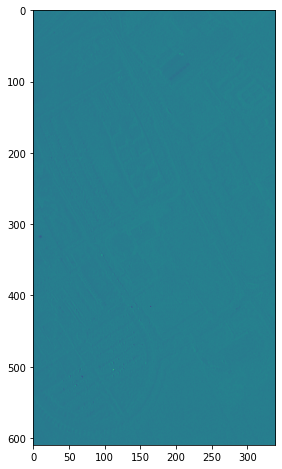

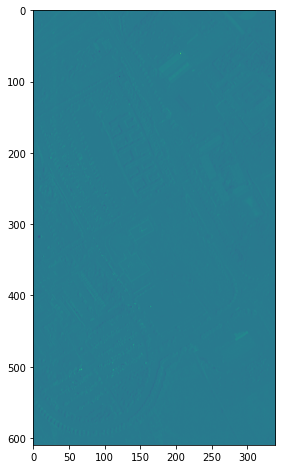

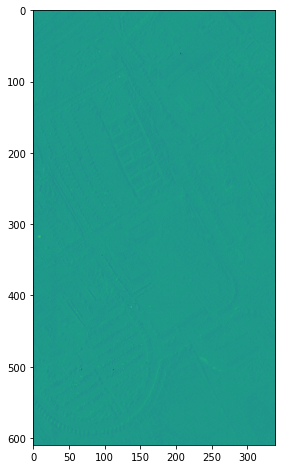

In [94]:
for i in range(8):
    plt.figure(figsize=(8,8))
    plt.imshow(phi_rescale_reshape[i])
    plt.show()

In [30]:
phi_reshape.shape

(8, 610, 340)

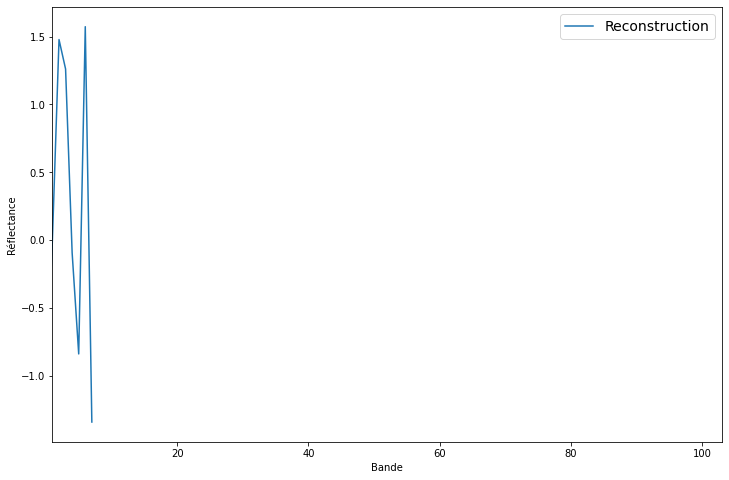

In [31]:
plt.figure(figsize=(12,8))
plt.plot(phi_reshape[:, 0, 0], label='Reconstruction')
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

Tout comme l'équation (1) peut se reformuler pour obtenir une solution matricielle (la matrice $\boldsymbol \Phi$), il est possible d'obtenir d'un coup l'erreur quadratique moyenne de l'image entière $\epsilon(\mathbf{X},\mathbf{\hat{X}} = \mathbf{E}\boldsymbol \Phi)$ (plutôt que de boucler sur tous les pixels).

**2.6) Visualisez la carte d'erreur quadratique moyenne de l'image hyperspectral pour le démélange obtenu**

In [32]:
hsi.shape, (E @ phi).shape

((610, 340, 103), (103, 207400))

In [33]:
mean_square_error(E @ phi, hsi.reshape((-1, 103)).T)

0.008181775051161562

On pourrait imaginer une stratégie de classification (naïve) suivante : chaque pixel est classifié selon son abondance fractionnelle majoritaire (puisqu'en théorie, plus l'abondance fractionelle est proche de $1$, plus le matériau correspondant est présent dans la signature spectrale du pixel en question). Même si le démélange obtenu précédemment avec les moindres carrés ordinaires devrait laisser à penser que cette stratégie est vouée à l'échec, on peut quand même y jeter un oeil.

Elle pourrait avoir particulièrement du sens pour les pixels supposés "purs", c'est à dire tous les pixels de la vérité terrain dont le label est compris entre $1$ et $8$ (les pixels labelisés $0$ sont de classe inconnue du point de vue de la classification, et les pixels labelisés $9$ correspondant à de l'ombre (d'un autre matériau), ils ne sont pas purs non plus).

**2.7) Appliquez la stratégie de classification évoquée juste au dessus, à savoir que chaque pixel est classifié selon son abondance fractionnelle majoritaire, et visualisez la carte de classification obtenue. Que pouvez vous en conclure ?**

In [34]:
phi.shape

(8, 207400)

In [35]:
phi

array([[-1.21999646, -2.25061442,  2.18942364, ...,  1.04790928,
         0.0224121 , -0.56792033],
       [ 0.01227112,  0.2783193 , -0.02390774, ...,  0.753854  ,
         0.79785151, -0.52329846],
       [ 1.47825416,  2.85768476,  0.05169524, ..., -0.84531526,
         1.34148659,  2.71883397],
       ...,
       [-0.83945189, -0.94616002, -0.36481841, ...,  0.13982032,
         0.04179041,  1.92960028],
       [ 1.57317949,  2.68468496, -1.71426234, ..., -1.15513837,
         0.12312997,  0.96488815],
       [-1.34161709, -2.88962742, -0.0272983 , ...,  0.75326608,
        -1.63083729, -3.75837964]])

In [36]:
phi[:, 0]

array([-1.21999646,  0.01227112,  1.47825416,  1.26122681, -0.09452185,
       -0.83945189,  1.57317949, -1.34161709])

In [37]:
classifi = np.argmax(phi, axis=0).reshape((610, 340))

In [38]:
classifi[gt == 0] = 0

In [39]:
gt.shape

(610, 340)

In [40]:
np.unique(classifi, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([169533,   5047,  11459,    441,    194,   5724,   2395,  12607]))

In [41]:
np.unique(gt, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([164624,   6631,  18649,   2099,   3064,   1345,   5029,   1330,
          3682,    947]))

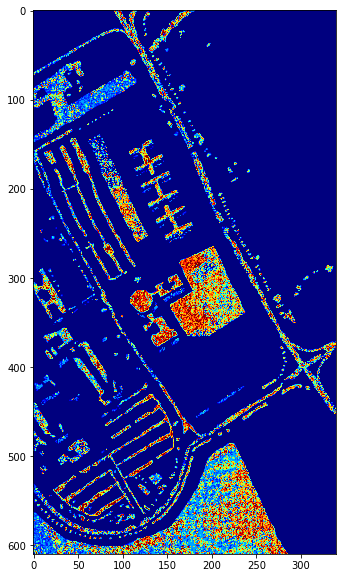

In [42]:
plt.figure(figsize=(15, 10))
plt.imshow(classifi, cmap='jet')

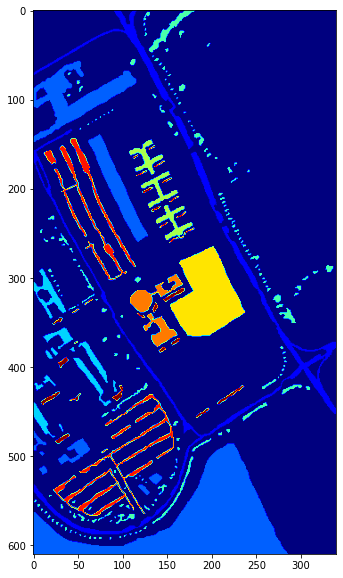

In [43]:
plt.figure(figsize=(15, 10))
plt.imshow(gt,cmap='jet')

L'évaluation qualitative précédente permet de donner des billes sur ce qui marche et ce qui ne marche pas à propos de la stratégie de classification appliquée. Mais cette évaluation qualitative doit être complétée par une évaluation quantitative plus rigoureuse, par le biais des métriques classiques de classification que vous connaissez.

**2.8) Complétez votre analyse précédente par une évaluation quantitative : taux de bonne classification globale, matrice de confusion et taux de bonne classification par classe**

In [44]:
def plot_confusion_matrix(labels, preds, class_names, title='Confusion matrix', log=False):
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale

    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('top')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.title(title)
    plt.show()

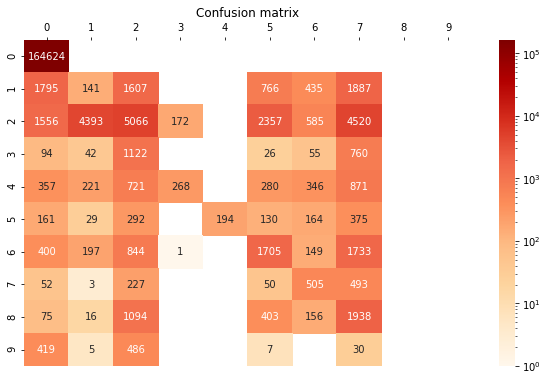

In [45]:
plot_confusion_matrix(gt, classifi, class_names=np.arange(10), log=True)

In [46]:
np.unique(gt, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([164624,   6631,  18649,   2099,   3064,   1345,   5029,   1330,
          3682,    947]))

In [47]:
np.unique(classifi, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([169533,   5047,  11459,    441,    194,   5724,   2395,  12607]))

In [48]:
#print(classification_report(gt, classifi, target_names=np.arange(10)))

## III. Régularisation de Tikhonov

Les techniques de régularisation sont très souvent utilisés pour la résolution de problèmes mal posés. Pour des problèmes linéaires sur-déterminés, c'est à dire du type $\mathbf{A}\mathbf{x} = \mathbf{b}$, où la matrice $\mathbf{A}$ possède plus de lignes que de colonnes - c'est notre cas ici - la régularisation va se matérialiser comme l'ajout d'un second terme $\mathcal{R}(\mathbf{x})$ au $RSS(\mathbf{x}) = \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 $ :

$$ RSS \text{ avec régularisation : }  \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + \mathcal{R}(\mathbf{x}), \quad (3)$$

de manière à ce que la solution de ce problème d'optimisation retrouver des propriétés souhaitables (de stabilité par exemple, c'est-à-dire qu'une légère perturbation de l'entrée n'entraine qu'une légère perturbation de la sortie, ce qui n'est pas le cas sans régularisation si $\mathbf{A}$ est mal conditionnée.

Le choix du terme de régularisation $\mathcal{R}(\mathbf{x})$ va bien sûr influer sur ces propriétés et sur la manière de résoudre le problème (3).

Dans le cas de la régularisation de Tikhonov, le terme de régularisation (aussi appelé _pénalité_) s'exprime comme $\mathcal{R}(\mathbf{x}) = \lambda \| \boldsymbol \Gamma \mathbf{x}\|_2^2$, où $\boldsymbol \Gamma$ (appelé matrice de Tikhonov) est déterminé en fonction du problème, et où $\lambda$ permet de donner plus où moins de poids à la régularisation par rapport au RSS.

Dans notre cas de démélange, $\boldsymbol \Gamma$ sera choisi comme la matrice identité, de manière à ce qu'on puisse réécrire le problème d'optimisation (en reprenant nos notations précédentes) : 

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_2^2\quad (4)$$

Ainsi, le terme de régularisation, en pénalisant les solutions ayant des composantes importantes (en valeur absolue), aura tendance à privilégier des solutions $\boldsymbol \phi$ dont la norme euclidienne est faible. La valeure de $\lambda$ permettra de jouer sur le degré de régularisation (et donc la liberté qu'aura $\boldsymbol \phi$ d'avoir des entrées de magnitude élevée) : plus $\lambda$ sera élevé, et plus la régularisation sera importante.

Sans surprise, le but de cette partie va être d'étudier l'influence de la régularisation de Tikhonov sur le problème d'estimation des abondances, et la comparaison avec la méthode des moindres carrés ordinaires. IL s'agira donc ici de reproduire ce qui a été fait dans la partie II, tout en intégrant l'étude de l'influence de $\lambda$ sur la qualité du démélange

**3.1) Dérivez sur papier la solution analytique du problème (4)** (car oui, elle existe, et elle est pas tellement plus compliquée que la solution des moindres carrés ordinaires)

In [49]:
np.identity(E.shape[1])

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [50]:
(E.T @ E).shape

(8, 8)

In [51]:
def analytic_solution_tikhonov(E, x, l):
    print(l)
    return np.linalg.inv(E.T @ E + l * np.identity(E.shape[1])) @ E.T @ x

**3.2) Implémentez le démélange avec régularisation de Tikhonov pour quelques spectres de l'image. Que remarquez vous qualitativement (comparaison de la signature originelle $\mathbf{x}$ avec la signature reconstruite) et quantitativement (valeur de l'erreur quadratique moyenne) par rapport aux solutions obtenues par moindres carrés ordinaires ? L'influence de $\lambda$ est elle bien conforme à celle prédite par la théorie ?**

In [52]:
phi_list = []
lambdas = np.linspace(0, 0.1, 10)
for l in lambdas:
    phi_list.append(analytic_solution_tikhonov(E, hsi.reshape((-1, Nbands)).T, l))

0.0
0.011111111111111112
0.022222222222222223
0.03333333333333333
0.044444444444444446
0.05555555555555556
0.06666666666666667
0.07777777777777778
0.08888888888888889
0.1


In [53]:
phi_list = np.array(phi_list)
phi_list.shape

(10, 8, 207400)

In [54]:
for i, l in enumerate(lambdas):
    print('{} \t {}'.format(l, mean_square_error(E @ phi_list[i], hsi.reshape((-1, Nbands)).T)))

0.0 	 0.008181775051161562
0.011111111111111112 	 0.01180264392472258
0.022222222222222223 	 0.012504864623943806
0.03333333333333333 	 0.012884215991732716
0.044444444444444446 	 0.013140424771399916
0.05555555555555556 	 0.0133358272646509
0.06666666666666667 	 0.013497569021131302
0.07777777777777778 	 0.013639561075663517
0.08888888888888889 	 0.013769662024459294
0.1 	 0.013892606015018481


-> comme gamma matrice identité, il est mieux d'avoir un lambda petit\
d'ou error min qd lambda = 0

**3.3) Vérifiez que vous retrouver bien la même solution que les solveurs classiques de ce problème de régularisation** (si vous voulez passer par une bibliothèque de *machine learning*, vous trouverez la solution du problème (4) sous son autre appelation, à savoir "régression Ridge").

In [55]:
hsi_reshaped = hsi.reshape((-1, 103))

In [56]:
X = hsi_reshaped

In [57]:
X.shape

(207400, 103)

In [58]:
E.shape

(103, 8)

In [59]:
phi = analytic_solution_tikhonov(E, X.T, 0.0)

0.0


In [60]:
phi.shape

(8, 207400)

In [61]:
from sklearn.linear_model import Ridge

In [62]:
clf = Ridge(alpha=0.0, solver='auto')

In [63]:
E.shape, X.shape

((103, 8), (207400, 103))

In [64]:
clf.fit(E, X.T)

Ridge(alpha=0.0)

In [65]:
phi[:,0]

array([-1.21999646,  0.01227112,  1.47825416,  1.26122681, -0.09452185,
       -0.83945189,  1.57317949, -1.34161709])

In [66]:
clf.coef_.shape

(207400, 8)

In [67]:
clf.intercept_.shape

(207400,)

In [68]:
clf.coef_[0]

array([ 0.62351542,  0.61793722,  3.37913063,  1.27310735, -0.08757717,
       -1.72960232,  3.28062581, -4.05311658])

In [69]:
print(clf.coef_.shape)
clf.coef_

(207400, 8)


array([[ 0.62351542,  0.61793722,  3.37913063, ..., -1.72960232,
         3.28062581, -4.05311658],
       [-1.71131449,  0.45550052,  3.41376609, ..., -1.20656412,
         3.18418035, -3.68284795],
       [ 2.53271418,  0.0888767 ,  0.40566796, ..., -0.53057824,
        -1.39630931, -0.53222162],
       ...,
       [-0.09517732,  0.37830514, -2.0239713 , ...,  0.69176633,
        -2.21385625,  2.43455643],
       [-2.27271977,  0.04381049, -1.02506293, ...,  1.15000818,
        -2.00260325,  1.74492013],
       [-0.53014799, -0.51088877,  2.75778167, ...,  1.91136169,
         0.9998726 , -3.81393648]])

In [70]:
clf.get_params()

{'alpha': 0.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [71]:
preds.shape

NameError: name 'preds' is not defined

In [72]:
plt.figure(figsize=(15, 15))
plt.imshow(preds,cmap='jet')

NameError: name 'preds' is not defined

<Figure size 1080x1080 with 0 Axes>

**3.4) Idem que pour les moindres carrés ordinaires, adaptez votre implémentation pour obtenir d'un coup la matrice d'abondances $\boldsymbol \Phi$ pour toute l'image. Affichez ces cartes d'abondances fractionnelles et la carte d'erreur quadratique moyenne de reconstruction pour l'image entière. Qu'en est-il de l'influence de $\lambda$ ?**

**3.5) Ré-appliquez la stratégie de classification du point 2.7) précédent, et étudiez les résultats qualitativement et quantitativement (toujours en fonction de $\lambda$). Quel est l'influence de la régularisation de Tikhonov sur les performances de classification ?**

## IV. Régularisation LASSO

La régularisation LASSO (pour Least Absolute Shrinkage and Selection Operator), proposée en 1996 par Robert Tibshirani, est très similaire à celle de Tikhonov, sauf que la pénalité prend la forme d'une norme $\mathcal{L}_1$ plutôt qu'une norme $\mathcal{L}_2$. Plus particulièrement, le problème (4) précédent prend la forme de

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_1\quad (5)$$

Cette régularisation, que l'on retrouve aussi sous le nom de _basis pursuit_ (une petite recherche bibliographique pourrait vous convaincre que les deux problèmes ne sont pas équivalents. Et pourtant, d'après la dualité Lagrangienne que vous verrez au S9, ils le sont).

Malgré sa forte ressemblance avec la régularisation de Tikhonov, la résolution du problème $(5)$ se passe moins bien puisqu'il n'existe pas de solution analytique dans le cas général (il en existe une dans le cas particulier où $E^T E = Id$, ce qui n'est clairement pas le cas dans notre étude). On doit donc se tourner vers des méthodes itératives, dont le splus utilisées pour la résolution de $(5)$ sont les méthodes LARS (Least Angle Regressions), de gradient proximaux et de descente de gradient par coordonnées.

Dans cette partie, vous allez implémenter la résolution de $(5)$ par descente de gradient par coordonnées. Bien qu'étant la plus abordable sur le plan théorique, cette méthode va vous amenez à toucher du doigt la notion de sous-différentiel, qui est au centre des algos de minimisation de fonctions convexes, mais non nécessairement différentiables.

**Cette partie n'est volontairement pas guidée. La partie II a permis de mettre en place un cadre de résolution et d'analyse du problème des moindres carrés, et la partie III a permis d'ajouter l'aspect régularisation au problème. À vous de jouer :**

**4.1) Cherchez** (vous trouverez une multitude de cours/slides/tutos plus ou moins clairs et didactiques sur le net)**, comprenez, et implémentez l'algorithme du LASSO par descente de gradient par coordonnées**

**4.2) Menez à bien l'analyse qualitative et quantitative des performances du LASSO sur le problème de démélange spectral (aussi bien sur quelques spectres que sur l'image entière), ainsi que toutes les comparaisons qui vous paraîtront pertinentes avec la résolution par moindres carrés ordinaires et moindres carrés avec régularisation de Tikhonov**

**4.3) Explicitez les conclusions que vous pouvez en tirer, et quelle méthode de résolution vous paraît la plus favorable étant données notamment les contraintes physiques de positivité et de somme à un sur les abondances (qui ne sont pas prises en compte ici).**

In [73]:
hsi.shape

(610, 340, 103)

In [74]:
E.shape

(103, 8)

In [75]:
data = hsi.reshape((-1, 103)).T

In [76]:
data.shape

(103, 207400)

In [77]:
phi.shape

(8, 207400)

In [78]:
class Lasso:
    def __init__(self, num_iters=100, lb=0.01):
        self.num_iters = num_iters
        self.lb = lb
    
    def fit(self, E, x):
        self.phi = np.ones((E.shape[1], x.shape[1]))
        
        # precompute z: shape=(E.shape[1],)=(n_features,)
        z = (E**2).sum(axis=0)

        # iterate over number of dimensions
        for i in range(self.num_iters):
            
            # compute loss function
            x_hat = E @ self.phi
            print(((x - x_hat)**2).sum(axis=0)[0] / 2.0 + self.lb * np.sum(np.abs(self.phi), axis=0)[0])
            
            # iterate over dimensions
            for j in range(E.shape[1]):             
                z_j = z[j]
                e_j = E[:, j].reshape((-1, 1))

                # don't want to consider this term in the sum
                theta_x_j = e_j @ self.phi[j].reshape((1, -1))
                
                # compute rho term
                # preds: shape=(E.shape[0], x.shape[1])=(n_samples, nb_dim_pred_var)
                preds = E @ self.phi
                rho = e_j.T @ (x - preds + theta_x_j)
                
                # update learning params: phi
                rho = rho.reshape((rho.shape[1],))
                self.phi[j][rho < -self.lb] = (rho[rho < -self.lb] + self.lb) / z_j
                self.phi[j][(rho > -self.lb) & (rho < self.lb)] = 0.
                self.phi[j][rho > self.lb] = (rho[rho > self.lb] - self.lb) / z_j

In [79]:
l_model = Lasso(lb=0.2)
l_model.fit(E, data)

206.320664298781
3.9026661050924787
3.7603825699518794
3.668675568874943
3.5885075487314264
3.5162319001968565
3.450561839935835
3.390422296046034
3.3348787271562976
3.2831392322048103
3.2345409892446235
3.198427891120819
3.165692226187543
3.134187570283289
3.1034306628580848
3.073216382642242
3.0434247831269823
3.013970323842064
2.9847862836340457
2.9558189043648486
2.927024467845939
2.898367397737636
2.8698188229268053
2.841355417346787
2.8129584410630195
2.784612941812205
2.75630708890564
2.728031617598532
2.6997793659805773
2.671544889421973
2.6433241400211394
2.615114200505511
2.5869130637184607
2.5587194502400563
2.530532657880196
2.5023524377853574
2.47347962699523
2.446714379375108
2.4206991332438474
2.3954848641074467
2.370931165651052
2.346858517039872
2.3231037737679605
2.29953203934311
2.276035857102867
2.2525314680614734
2.2289548327038866
2.205258080251955
2.1814064907678556
2.1573759722423893
2.133150965598348
2.1087227114151808
2.084087820019554
2.0592470951656594
2.034